In [82]:
import numpy as np
import pandas as pd
import os
import glob
import joblib
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerBase
import seaborn as sns

from nilearn import plotting 
from nilearn.image import smooth_img, swap_img_hemispheres

from nilearn.input_data import NiftiMasker
import nibabel as nib

import scipy.stats
from scipy.stats import pearsonr, spearmanr, ttest_ind
import statsmodels.api as sm

import llms_brain_lateralization as lbl
from llms_brain_lateralization import make_dir

In [83]:
rc={'font.size': 12, 'axes.labelsize': 14, 
    'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)
sns.set_style('darkgrid')

In [84]:
save_fig = True

In [85]:
if save_fig:
    fig_folder = lbl.figures_folder
    make_dir(fig_folder)

In [86]:
nifti_masker = NiftiMasker(mask_img='mask_lpp_en.nii.gz')
nifti_masker.fit()

n_voxels = nifti_masker.n_elements_

In [87]:
glm_folder = lbl.llms_brain_correlations

In [88]:
steps = [0, 1, 8, 16, 64, 128, 256, 512, 1000, 3000, 13000, 23000, 33000, 43000, 53000, 63000, 73000, 83000, 93000, 103000, 113000, 123000, 133000, 143000]

In [89]:
model_names = ["EleutherAI/pythia-12b-deduped-step:" + str(step) for step in steps]
n_layers = 32

In [90]:
n_models = len(model_names)
print(n_models)

24


In [91]:
corr_layers_voxels_models = []
for model_name in model_names:
    corr_layers_voxels = []
    for idx_layer in range(32):
        filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, idx_layer))
        with open(filename, 'rb') as f:
            corr_voxels = joblib.load(f)
        corr_layers_voxels.append(corr_voxels)
        print(corr_layers_voxels)
    corr_layers_voxels_models.append(np.array(corr_layers_voxels))
print(corr_layers_voxels_models)

[array([ 0.19053786,  0.18490929,  0.21934072, ...,  0.05336162,
        0.02403768, -0.04170022])]
[array([ 0.19053786,  0.18490929,  0.21934072, ...,  0.05336162,
        0.02403768, -0.04170022]), array([ 0.2106198 ,  0.20611985,  0.23125723, ...,  0.08163284,
        0.04373094, -0.04659107])]
[array([ 0.19053786,  0.18490929,  0.21934072, ...,  0.05336162,
        0.02403768, -0.04170022]), array([ 0.2106198 ,  0.20611985,  0.23125723, ...,  0.08163284,
        0.04373094, -0.04659107]), array([ 0.19613331,  0.19402024,  0.21135032, ...,  0.07488406,
        0.02987346, -0.03942732])]
[array([ 0.19053786,  0.18490929,  0.21934072, ...,  0.05336162,
        0.02403768, -0.04170022]), array([ 0.2106198 ,  0.20611985,  0.23125723, ...,  0.08163284,
        0.04373094, -0.04659107]), array([ 0.19613331,  0.19402024,  0.21135032, ...,  0.07488406,
        0.02987346, -0.03942732]), array([ 0.19432614,  0.18526923,  0.20276321, ...,  0.0595192 ,
       -0.00161258, -0.05352938])]
[array

In [92]:
print(corr_layers_voxels_models)
color_models = list(sns.color_palette('plasma', n_colors=len(corr_layers_voxels_models)))
print(len(corr_layers_voxels_models))

[array([[ 0.19053786,  0.18490929,  0.21934072, ...,  0.05336162,
         0.02403768, -0.04170022],
       [ 0.2106198 ,  0.20611985,  0.23125723, ...,  0.08163284,
         0.04373094, -0.04659107],
       [ 0.19613331,  0.19402024,  0.21135032, ...,  0.07488406,
         0.02987346, -0.03942732],
       ...,
       [ 0.17383033,  0.16839164,  0.2004641 , ...,  0.06661168,
         0.01287441, -0.04179408],
       [ 0.17490851,  0.16846533,  0.20064117, ...,  0.06716588,
         0.01471536, -0.04328814],
       [ 0.17386683,  0.16740856,  0.20044826, ...,  0.06578663,
         0.00874289, -0.04422904]]), array([[ 0.19053786,  0.18490929,  0.21934072, ...,  0.05336162,
         0.02403768, -0.04170022],
       [ 0.2106198 ,  0.20611985,  0.23125723, ...,  0.08163284,
         0.04373094, -0.04659107],
       [ 0.19613331,  0.19402024,  0.21135032, ...,  0.07488406,
         0.02987346, -0.03942732],
       ...,
       [ 0.17383033,  0.16839164,  0.2004641 , ...,  0.06661168,
        

In [93]:
# mean correlation for each voxel, for each model, using best layer for each voxel
# n_models x n_voxels
corr_voxels_models = []
for corr_layers_voxels in corr_layers_voxels_models:
    if corr_layers_voxels.size == 0:
        # Handle empty array case, e.g., append a default value or skip
        corr_voxels_models.append(np.nan)  # or any default value you prefer
    else:
        corr_voxels_models.append(np.max(corr_layers_voxels, axis=0))
corr_voxels_models = np.array(corr_voxels_models)

# mean correlation for each model, using best layer for each voxel, averaged over all voxels
# n_voxels
corr_models = np.array([np.mean(corr_voxels) for corr_voxels in corr_voxels_models])

# mean correlation for each layer of each model, averaged over all voxels
# n_models x n_layers 
corr_layers_models = [np.mean(corr_layers, axis=1) for corr_layers in corr_layers_voxels_models]
# restrict to left and right hemisphere
corr_l_models = corr_voxels_models[:,:n_voxels//2]
corr_r_models = corr_voxels_models[:,n_voxels//2:]

torch.save([model_names, corr_voxels_models, corr_models, corr_layers_models, corr_l_models, corr_r_models], 'metrics/' + "12bmetrics.pt")


In [94]:
# left: red, right: green (as for port and starboard; should be colorblind compatible though)
l_r_colors = sns.color_palette('colorblind', n_colors=4)[2:][::-1]

In [95]:
np.logspace(2,7,16)[8]

46415.888336127726

In [147]:
def plot_xy(xvalue, yvalue, xlabel=None, ylabel=None, logx=False, invert_xaxis=False, figsize=(6.4, 4.8), title=""):        
    for i in range(len(xvalue)):
        if xvalue[i] <= 0.5:
            xvalue[i] = 10**-1
    fh = plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    fh.suptitle(title)
    sns.regplot(x=xvalue,
                y=yvalue,
                logx=logx, ax=ax);
    if logx:
        ax.set_xscale('log')
    if invert_xaxis:
        ax.invert_xaxis()
    ax.set_xlabel(xlabel)      
    ax.set_ylabel(ylabel)
    if logx:
         r, p = pearsonr(np.log(xvalue), yvalue)
    else:
         r, p = pearsonr(xvalue, yvalue)
   
    fh.text(0.15, 0.85,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
            ha='left', va='top', fontsize=11)
    return fh

def pvalue2str(pvalue):
    if pvalue <= 0.001:
        return '***'
    elif pvalue <= 0.01:
        return '**'
    elif pvalue <= 0.05:
        return '*'
    else:
        return 'ns'

/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


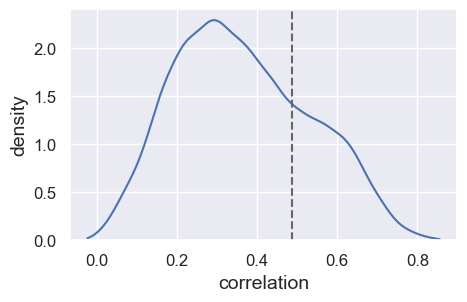

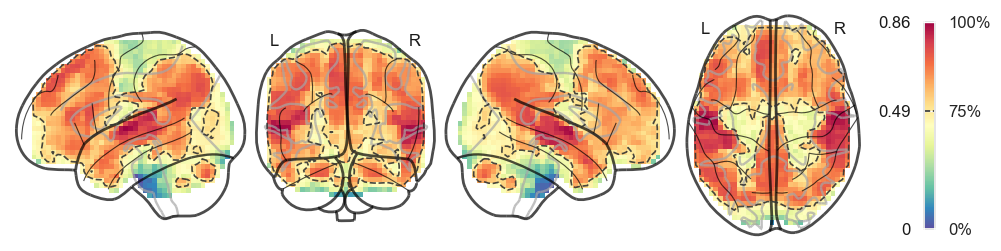

In [141]:
########################################## Using reliable voxels: best 25% voxels ##########################################

n_trials_split = 10
filename = 'corr_group_split_{}trials.gz'.format(n_trials_split)
corr_split = joblib.load(filename)
corr_split_mean = np.mean(corr_split, axis=0)

is_voxel_reliable = corr_split_mean > np.percentile(corr_split_mean, 75)

#### rv for reliable voxels

# mean correlation for each voxel, for each model, using best layer for each voxel
# n_models x n_voxels
corr_voxels_models_rv = np.array([np.max(corr_layers_voxels[:,is_voxel_reliable], axis=0)
                                  for corr_layers_voxels in corr_layers_voxels_models])

# mean correlation for each model, using best layer for each voxel, averaged over all voxels
# n_voxels
corr_models_rv = np.array([np.mean(corr_voxels[is_voxel_reliable]) for corr_voxels in corr_voxels_models])

# mean correlation for each layer of each model, averaged over all voxels
# n_models x n_layers 
corr_layers_models_rv = [np.mean(corr_layers[:, is_voxel_reliable], axis=1) for corr_layers in corr_layers_voxels_models]

# restrict to left and right hemisphere
# n_models x n_voxels//2
corr_l_models_rv = corr_l_models[:,is_voxel_reliable[:n_voxels//2]]
corr_r_models_rv = corr_r_models[:,is_voxel_reliable[n_voxels//2:]]

fh = plt.figure(figsize=(5,3))
ax = plt.subplot(111)
sns.kdeplot(corr_split_mean, cut=0., ax=ax)
plt.axvline(np.percentile(corr_split_mean, 75), ls='--', c='0.4');
plt.xlabel('correlation')
plt.ylabel('density')
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'reliable_voxels_distribution.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

imgtmp = nifti_masker.inverse_transform(corr_split_mean)
fh = plt.figure(figsize=(12,3))
ax = plt.subplot(111)
display = plotting.plot_glass_brain(imgtmp, threshold=0., display_mode='lyrz', 
                          vmin=0., cmap='Spectral_r', 
                          plot_abs=True, colorbar=True, axes=ax)
display.add_contours(imgtmp, levels=[np.percentile(corr_split_mean, 75)], colors='0.2', linewidths=1.2, alpha=0.9, linestyles='dashed')

display._colorbar_ax.set_yticks([0., np.percentile(corr_split_mean, 75), np.max(corr_split_mean)])
ylim = display._colorbar_ax.get_ylim()  
ax2 = display._colorbar_ax.twinx()
ax2.set_ylim(ylim)
ax2.set_yticks([0., np.percentile(corr_split_mean, 75), np.max(corr_split_mean)], ['0%', '75%', '100%'])
ax2.yaxis.set_tick_params(width=0)
#display._cbar._
ax2.axhline(np.percentile(corr_split_mean, 75), ls='--', lw=1.2, color='0.2')

plotting.show() 

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'reliable_voxels_75.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

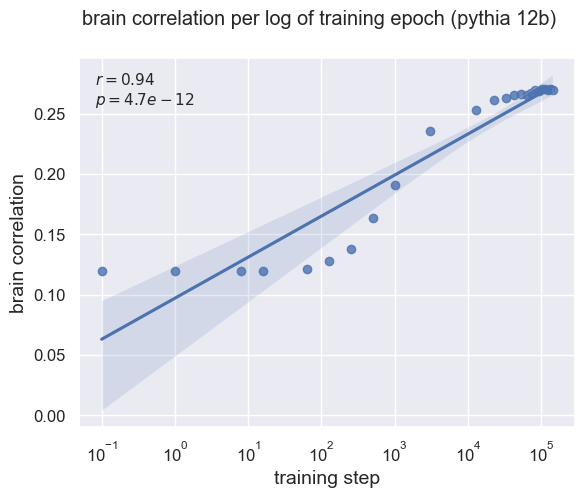

In [148]:
fh = plot_xy(steps, [i for i in corr_models], 
             xlabel='training step', ylabel='brain correlation', 
             logx=True, title='brain correlation per log of training epoch (pythia 12b)')
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_params_corr.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

In [99]:
# ça peut ressembler à l'inverse d'une loss function...

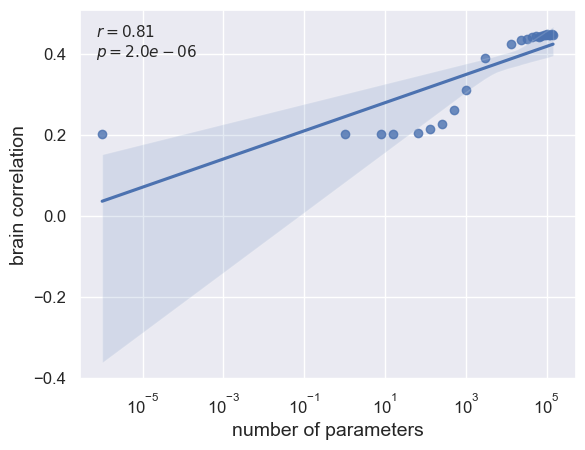

In [100]:
fh = plot_xy(steps, corr_models_rv, 
             xlabel='number of parameters', ylabel='brain correlation', 
             logx=True)
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_params_corr_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

In [101]:
################################ baselines ################################

# look at random embeddings
corr_random_emb_300 = []
for seed in range(1,11):
    model_name ='random_embedding_300d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_random_emb_300.append(corr)
corr_random_emb_300 = np.mean(corr_random_emb_300, axis=0)

corr_random_emb_1024 = []
for seed in range(1,11):
    model_name ='random_embedding_1024d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_random_emb_1024.append(corr)
corr_random_emb_1024 = np.mean(corr_random_emb_1024, axis=0)

corr2_random_emb_1024 = []
for seed in range(11,21):
    model_name ='random_embedding_1024d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr2_random_emb_1024.append(corr)
corr2_random_emb_1024 = np.mean(corr2_random_emb_1024, axis=0)

corr_random_vec_1024 = []
for seed in range(1,9):
    model_name ='random_vector_1024d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_random_vec_1024.append(corr)
corr_random_vec_1024 = np.mean(corr_random_vec_1024, axis=0)

corr_lograndom_vec_1024 = []
for seed in range(10,18):
    model_name ='random_vector_1024d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_lograndom_vec_1024.append(corr)
corr_lograndom_vec_1024 = np.mean(corr_lograndom_vec_1024, axis=0)

corr_exprandom_vec_1024 = []
for seed in range(30,40):
    model_name ='random_vector_1024d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_exprandom_vec_1024.append(corr)
    print(corr_exprandom_vec_1024)
corr_exprandom_vec_1024 = np.mean(corr_exprandom_vec_1024, axis=0)

corr_cauchyrandom_vec_1024 = []
for seed in range(40,50):
    model_name ='random_vector_1024d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_cauchyrandom_vec_1024.append(corr)
corr_cauchyrandom_vec_1024 = np.mean(corr_cauchyrandom_vec_1024, axis=0)

corr_georandom_vec_1024 = []
for seed in range(50,60):
    model_name ='random_vector_1024d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_georandom_vec_1024.append(corr)
corr_georandom_vec_1024 = np.mean(corr_georandom_vec_1024, axis=0)

corr_lograndom_emb_1024 = []
for seed in range(20,28):
    model_name ='random_embedding_1024d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_lograndom_emb_1024.append(corr)
corr_lograndom_emb_1024 = np.mean(corr_lograndom_emb_1024, axis=0)

corr_exprandom_emb_1024 = []
for seed in range(30,39):
    model_name ='random_embedding_1024d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_exprandom_emb_1024.append(corr)
corr_exprandom_emb_1024 = np.mean(corr_exprandom_emb_1024, axis=0)

corr_cauchyrandom_emb_1024 = []
for seed in range(40,49):
    model_name ='random_embedding_1024d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_cauchyrandom_emb_1024.append(corr)
corr_cauchyrandom_emb_1024 = np.mean(corr_cauchyrandom_emb_1024, axis=0)

corr_georandom_emb_1024 = []
for seed in range(50,59):
    model_name ='random_embedding_1024d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_georandom_emb_1024.append(corr)
corr_georandom_emb_1024 = np.mean(corr_georandom_emb_1024, axis=0)

# GloVe
model_name ='glove'
filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
with open(filename, 'rb') as f:
    corr_glove = joblib.load(f)

[array([ 0.10687953,  0.12108605,  0.15201035, ...,  0.0576815 ,
        0.04256937, -0.00210198])]
[array([ 0.10687953,  0.12108605,  0.15201035, ...,  0.0576815 ,
        0.04256937, -0.00210198]), array([0.12487805, 0.137588  , 0.15891683, ..., 0.09464362, 0.08575432,
       0.0018003 ])]
[array([ 0.10687953,  0.12108605,  0.15201035, ...,  0.0576815 ,
        0.04256937, -0.00210198]), array([0.12487805, 0.137588  , 0.15891683, ..., 0.09464362, 0.08575432,
       0.0018003 ]), array([0.12190748, 0.13115199, 0.1401188 , ..., 0.07663137, 0.03324476,
       0.01937137])]
[array([ 0.10687953,  0.12108605,  0.15201035, ...,  0.0576815 ,
        0.04256937, -0.00210198]), array([0.12487805, 0.137588  , 0.15891683, ..., 0.09464362, 0.08575432,
       0.0018003 ]), array([0.12190748, 0.13115199, 0.1401188 , ..., 0.07663137, 0.03324476,
       0.01937137]), array([0.12553028, 0.14935105, 0.15598776, ..., 0.08418478, 0.06319347,
       0.04337083])]
[array([ 0.10687953,  0.12108605,  0.15201

/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

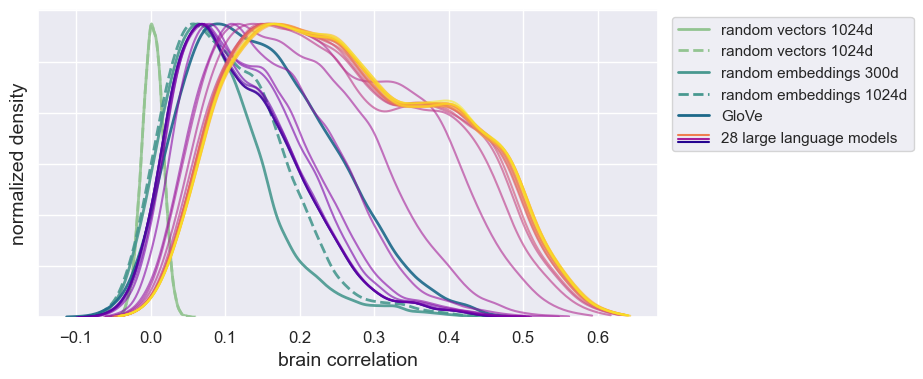

In [102]:
color_baseline = sns.color_palette('crest', n_colors=15)[::5]

class MyLegendHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        lines = []
        n_models = len(color_models[::8])
        for i, color in enumerate(color_models[::8]):
             lines.append(plt.Line2D([x0,y0+width], 
                               [i/n_models*height,i/n_models*height], 
                               color=color))
        return lines

fh = plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
sns.kdeplot(corr_random_vec_1024, c=color_baseline[0], lw=2, alpha=0.9, cut=0., ax=ax);
#ax.set_yticks([])
ax.set_yticklabels([])
ax.tick_params(axis='y', length=0)
plt.xlabel('brain correlation')
plt.ylabel('normalized density')
ax = plt.twinx()
sns.kdeplot(corr_random_vec_1024, c=color_baseline[0], ls='--', lw=2, alpha=0.9, cut=0.);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_random_emb_300, c=color_baseline[1], lw=2, alpha=0.9, cut=0.);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_random_emb_1024, c=color_baseline[1], ls='--', lw=2, alpha=0.9, cut=0.);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_glove, c=color_baseline[2], lw=2, alpha=0.9, cut=0.);
ax.grid(None)
ax.axis('off')
for corr_voxels, color in zip(corr_voxels_models, color_models):
    ax = plt.twinx()
    sns.kdeplot(corr_voxels, color=color, lw=1.5, alpha=0.6, cut=0.);
    ax.grid(None)
    ax.axis('off')

plt.plot([0], c=color_baseline[0], lw=2, label='random vectors 1024d')
plt.plot([0], c=color_baseline[0], lw=2, ls='--', label='random vectors 1024d')
plt.plot([0], c=color_baseline[1], lw=2, label='random embeddings 300d')
plt.plot([0], c=color_baseline[1], lw=2, ls='--', label='random embeddings 1024d')
plt.plot([0], c=color_baseline[2], lw=2, label='GloVe')

hllm, = plt.plot([0], label='28 large language models')

ax.tick_params(axis='y', labelleft='off')

plt.legend(handler_map={hllm: MyLegendHandler()}, bbox_to_anchor=(1.01,1), loc='upper left')

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'distribution_correlation_models_baselines.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

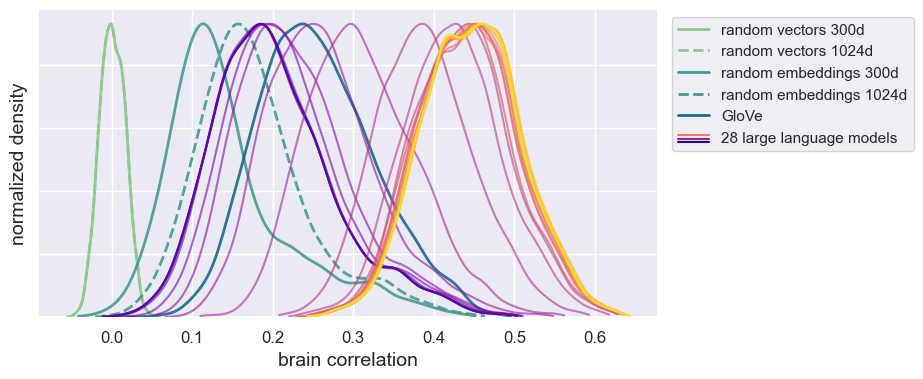

In [103]:
fh = plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
sns.kdeplot(corr_random_vec_1024[is_voxel_reliable], c=color_baseline[0], lw=2, alpha=0.9, cut=0., ax=ax);
ax.set_yticklabels([])
ax.tick_params(axis='y', length=0)
plt.xlabel('brain correlation')
plt.ylabel('normalized density')
ax = plt.twinx()
sns.kdeplot(corr_random_vec_1024[is_voxel_reliable], c=color_baseline[0], ls='--', lw=2, alpha=0.9, cut=0., ax=ax);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_random_emb_300[is_voxel_reliable], c=color_baseline[1], lw=2, alpha=0.9, cut=0., ax=ax);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_random_emb_1024[is_voxel_reliable], c=color_baseline[1], ls='--', lw=2, alpha=0.9, cut=0., ax=ax);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_glove[is_voxel_reliable], c=color_baseline[2], lw=2, alpha=0.9, cut=0., ax=ax);
ax.grid(None)
ax.axis('off')
for corr_voxels, color in zip(corr_voxels_models, color_models):
    ax = plt.twinx()
    sns.kdeplot(corr_voxels[is_voxel_reliable], color=color, lw=1.5, alpha=0.6, cut=0., ax=ax);
    ax.grid(None)
    ax.axis('off')

plt.plot([0], c=color_baseline[0], lw=2, label='random vectors 300d')
plt.plot([0], c=color_baseline[0], lw=2, ls='--', label='random vectors 1024d')
plt.plot([0], c=color_baseline[1], lw=2, label='random embeddings 300d')
plt.plot([0], c=color_baseline[1], lw=2, ls='--', label='random embeddings 1024d')
plt.plot([0], c=color_baseline[2], lw=2, label='GloVe')

hllm, = plt.plot([0], label='28 large language models')

ax.tick_params(axis='y', labelleft='off')

plt.legend(handler_map={hllm: MyLegendHandler()}, bbox_to_anchor=(1.01,1), loc='upper left')

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'distribution_correlation_models_baselines_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

EleutherAI/pythia-12b-deduped-step:133000


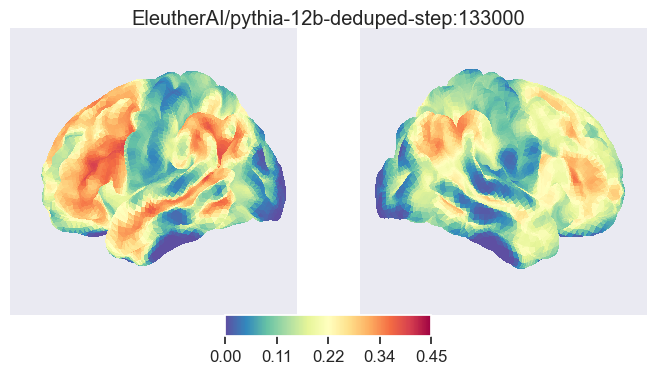

EleutherAI/pythia-12b-deduped-step:0


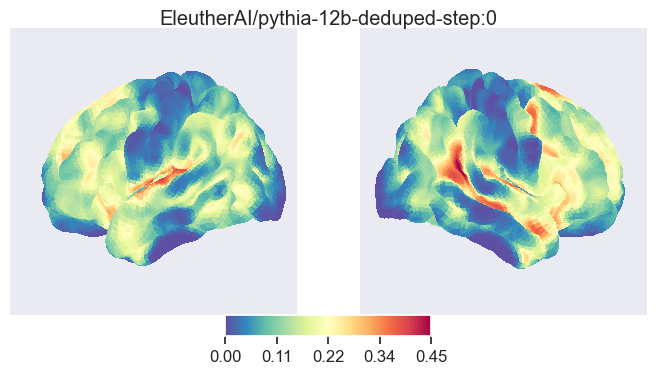

In [104]:
######## best model ########
idx_best_model = np.argmax(corr_models_rv)

print(model_names[idx_best_model])
corr_voxels = corr_voxels_models[idx_best_model]

imgtmp = nifti_masker.inverse_transform(corr_voxels - corr_random_emb_1024)

vmax = np.max(corr_voxels - corr_random_emb_1024)

fh, axes = plotting.plot_img_on_surf(imgtmp,
                                     surf_mesh='fsaverage5',
                                     views=['lateral'],
                                     hemispheres=['left', 'right'],
                                     vmin=0., vmax=vmax,
                                     cmap='Spectral_r',
                                     symmetric_cbar=False,
                                     cbar_tick_format='%.2f',
                                     colorbar=True,
                                     title=str(model_names[idx_best_model]))
for ax in axes[0:2]:
    ax.set_box_aspect(None, zoom=1.45)
fh.set_size_inches(7, 4.3)
plotting.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'brain_best_over_random_emb.pdf'), bbox_inches='tight', 
               transparent=True, facecolor=(1,1,1,0))
    
######## worst model ########
idx_worst_model = np.argmin(corr_models_rv)

print(model_names[idx_worst_model])

corr_voxels = corr_voxels_models[idx_worst_model]

imgtmp = nifti_masker.inverse_transform(corr_voxels)

fh, axes = plotting.plot_img_on_surf(imgtmp,
                                     surf_mesh='fsaverage5',
                                     views=['lateral'],
                                     hemispheres=['left', 'right'],
                                     vmin=0., vmax=vmax,
                                     cmap='Spectral_r',
                                     symmetric_cbar=False,
                                     cbar_tick_format='%.2f',
                                     colorbar=True,
                                     title=str(model_names[idx_worst_model]))
for ax in axes[0:2]:
    ax.set_box_aspect(None, zoom=1.45)
fh.set_size_inches(7, 4.3)
plotting.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'brain_worst_over_random_emb.pdf'), bbox_inches='tight', 
               transparent=True, facecolor=(1,1,1,0))    

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from nilearn import plotting

# Les données doivent être préparées à l'avance
# steps = [1_000, *range(10_000, 140_000, 10_000), 143000]
# corr_models_rv = [...]
vmax = np.max(np.max(corr_voxels_models, axis=0)-corr_random_emb_1024)
for step_idx in range(len(steps)):
    idx_best_model = step_idx
    print(f'Generating image for step {steps[step_idx]}')
    
    corr_voxels = corr_voxels_models[idx_best_model]
    imgtmp = nifti_masker.inverse_transform(corr_voxels-corr_random_emb_1024)
    
    # Enregistrez l'image directement sans utiliser axes
    temp_filename = f'temp_{step_idx}.png'
    plotting.plot_img_on_surf(imgtmp,
                              surf_mesh='fsaverage5',
                              views=['lateral'],
                              hemispheres=['left', 'right'],
                              vmin=0., vmax=vmax,
                              cmap='Spectral_r',
                              symmetric_cbar=False,
                              cbar_tick_format='%.2f',
                              colorbar=True,
                              title=str(model_names[idx_best_model]))
    
    plt.savefig(temp_filename)
    plt.close()

# Optionnel : sauvegardez toutes les images sous forme de GIF pour vérification
images = [imageio.imread(f'temp_{i}.png') for i in range(len(steps))]
imageio.mimsave('brain_correlations.gif', images, duration=0.5)


Generating image for step 0.1
Generating image for step 1
Generating image for step 8
Generating image for step 16
Generating image for step 64
Generating image for step 128
Generating image for step 256
Generating image for step 512
Generating image for step 1000
Generating image for step 3000
Generating image for step 13000
Generating image for step 23000
Generating image for step 33000
Generating image for step 43000
Generating image for step 53000
Generating image for step 63000
Generating image for step 73000
Generating image for step 83000
Generating image for step 93000
Generating image for step 103000
Generating image for step 113000
Generating image for step 123000
Generating image for step 133000
Generating image for step 143000


/var/folders/ky/0mnswx1j4slddjt0jztl2k6c0000gn/T/ipykernel_40226/612464023.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f'temp_{i}.png') for i in range(len(steps))]


In [106]:
import ipywidgets as widgets
from IPython.display import display, Image

# Créez un widget slider
step_slider = widgets.IntSlider(min=0, max=len(steps)-1, step=1, description='Step Index')

# Fonction pour afficher une image donnée par l'indice du slider
def show_image(step_idx):
    display(Image(filename=f'temp_{step_idx}.png'))

# Connectez le slider à la fonction de plot
interactive_plot = widgets.interactive(show_image, step_idx=step_slider)
display(interactive_plot)


interactive(children=(IntSlider(value=0, description='Step Index', max=23), Output()), _dom_classes=('widget-i…

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from nilearn import plotting

# Les données doivent être préparées à l'avance
# steps = [1_000, *range(10_000, 140_000, 10_000), 143000]
# corr_models_rv = [...]
vmax = np.max(np.max(corr_voxels_models, axis=0))
for step_idx in range(len(steps)):
    idx_best_model = step_idx
    print(f'Generating image for step {steps[step_idx]}')
    
    corr_voxels = corr_voxels_models[idx_best_model]
    imgtmp = nifti_masker.inverse_transform(corr_voxels)
    
    # Enregistrez l'image directement sans utiliser axes
    temp_filename = f'tempnocorr_{step_idx}.png'
    plotting.plot_img_on_surf(imgtmp,
                              surf_mesh='fsaverage5',
                              views=['lateral'],
                              hemispheres=['left', 'right'],
                              vmin=0., vmax=vmax,
                              cmap='Spectral_r',
                              symmetric_cbar=False,
                              cbar_tick_format='%.2f',
                              colorbar=True,
                              title=str(model_names[idx_best_model]))
    
    plt.savefig(temp_filename)
    plt.close()

# Optionnel : sauvegardez toutes les images sous forme de GIF pour vérification
images = [imageio.imread(f'tempnocorr_{i}.png') for i in range(len(steps))]
imageio.mimsave('brain_correlations_nocorr.gif', images, duration=0.5)


Generating image for step 1e-06
Generating image for step 1
Generating image for step 8
Generating image for step 16
Generating image for step 64
Generating image for step 128
Generating image for step 256
Generating image for step 512
Generating image for step 1000
Generating image for step 3000
Generating image for step 13000
Generating image for step 23000
Generating image for step 33000
Generating image for step 43000
Generating image for step 53000
Generating image for step 63000
Generating image for step 73000
Generating image for step 83000
Generating image for step 93000
Generating image for step 103000
Generating image for step 113000
Generating image for step 123000
Generating image for step 133000
Generating image for step 143000


/var/folders/ky/0mnswx1j4slddjt0jztl2k6c0000gn/T/ipykernel_40226/3354443006.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f'tempnocorr_{i}.png') for i in range(len(steps))]


In [149]:
import ipywidgets as widgets
from IPython.display import display, Image

# Créez un widget slider
step_slider = widgets.IntSlider(min=0, max=len(steps)-1, step=1, description='Step Index')

# Fonction pour afficher une image donnée par l'indice du slider
def show_image(step_idx):
    display(Image(filename=f'tempnocorr_{step_idx}.png'))

# Connectez le slider à la fonction de plot
interactive_plot = widgets.interactive(show_image, step_idx=step_slider)
display(interactive_plot)


interactive(children=(IntSlider(value=0, description='Step Index', max=23), Output()), _dom_classes=('widget-i…

In [109]:
################################ L/R Asymmetries ################################
# whole brain

#l r asym in baselines
for corr_voxels in [corr_random_emb_300, corr_random_emb_1024, corr2_random_emb_1024, corr_lograndom_emb_1024,
                    corr_glove, corr_random_vec_1024, corr_lograndom_vec_1024]:
    print((corr_voxels[:n_voxels//2].mean() - corr_voxels[n_voxels//2:].mean()) / np.mean(corr_voxels))
    print((corr_voxels[:n_voxels//2].mean() - corr_voxels[n_voxels//2:].mean()))
    print("------")

-0.1318087955646224
-0.012043223110262943
------
-0.09305774345594336
-0.009729877718684873
------
-0.098615436443387
-0.010434623951069422
------
-0.09652146942780207
-0.01016679742074951
------
-0.02086014444656871
-0.0031377150178906466
------
-0.2979051570884933
-0.0007526131200642923
------
-0.2622360175774576
-0.015813369890825248
------


In [110]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from nilearn import plotting


vmax = np.max(np.max(corr_voxels_models, axis=0)-corr_random_emb_1024)
for i, random_emb_corr in enumerate([corr_random_emb_300, corr_random_emb_1024, corr2_random_emb_1024,
                                     corr_lograndom_emb_1024, corr_random_vec_1024, corr_lograndom_vec_1024,
                                     corr_glove]):
    print("generation img no correction")
    corr_voxels = random_emb_corr
    imgtmp = nifti_masker.inverse_transform(corr_voxels)
    
    # Enregistrez l'image directement sans utiliser axes
    temp_filename = f'tempbruit_{i}.png'
    plotting.plot_img_on_surf(imgtmp,
                              surf_mesh='fsaverage5',
                              views=['lateral'],
                              hemispheres=['left', 'right'],
                              vmin=0., vmax=vmax,
                              cmap='Spectral_r',
                              symmetric_cbar=False,
                              cbar_tick_format='%.2f',
                              colorbar=True,
                              title=str(model_names[idx_best_model]))
    
    plt.savefig(temp_filename)
    plt.close()

# Optionnel : sauvegardez toutes les images sous forme de GIF pour vérification
images = [imageio.imread(f'tempbruit_{i}.png') for i in range(6)]
imageio.mimsave('tempbruit_.gif', images, duration=0.5)


generation img no correction
generation img no correction
generation img no correction
generation img no correction
generation img no correction
generation img no correction
generation img no correction


/var/folders/ky/0mnswx1j4slddjt0jztl2k6c0000gn/T/ipykernel_40226/299850568.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f'tempbruit_{i}.png') for i in range(6)]


In [111]:
import ipywidgets as widgets
from IPython.display import display, Image

# Créez un widget slider
step_slider = widgets.IntSlider(min=0, max=6, step=1, description='Step Index')

# Fonction pour afficher une image donnée par l'indice du slider
def show_image(step_idx):
    display(Image(filename=f'tempbruit_{step_idx}.png'))

# Connectez le slider à la fonction de plot
interactive_plot = widgets.interactive(show_image, step_idx=step_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Step Index', max=6), Output()), _dom_classes=('widget-in…

In [112]:
def get_var_name(var):
    for name, value in locals().items():
        if value is var:
            return name

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from nilearn import plotting


vmax = np.max(np.max(corr_voxels_models, axis=0)-corr_random_emb_1024)
noms = ['corr_random_emb_300', 'corr_random_emb_1024', 'corr2_random_emb_1024',
        'corr_lograndom_emb_1024', 'corr_exprandom_emb_1024', 'corr_cauchyrandom_emb_1024',
        'corr_georandom_emb_1024','corr_random_vec_1024', 'corr_lograndom_vec_1024',
        'corr_exprandom_vec_1024', 'corr_cauchyrandom_vec_1024', 'corr_georandom_vec_1024',
        'corr_glove']
for i, random_emb_corr in enumerate([corr_random_emb_300, corr_random_emb_1024, corr2_random_emb_1024,
                                     corr_lograndom_emb_1024, corr_exprandom_emb_1024,
                                     corr_georandom_emb_1024, corr_cauchyrandom_emb_1024,
                                     corr_random_vec_1024, corr_lograndom_vec_1024,
                                     corr_exprandom_vec_1024, corr_georandom_vec_1024, corr_cauchyrandom_vec_1024,
                                     corr_glove]):
    print("generation img no correction")
    corr_voxels = random_emb_corr
    imgtmp = nifti_masker.inverse_transform(corr_voxels)
    
    # Enregistrez l'image directement sans utiliser axes
    temp_filename = f'tempbruit_{i}.png'
    plotting.plot_img_on_surf(imgtmp,
                              surf_mesh='fsaverage5',
                              views=['lateral'],
                              hemispheres=['left', 'right'],
                              vmin=0., vmax=vmax,
                              cmap='Spectral_r',
                              symmetric_cbar=False,
                              cbar_tick_format='%.2f',
                              colorbar=True,
                              title=noms[i])
    
    plt.savefig(temp_filename)
    plt.close()

# Optionnel : sauvegardez toutes les images sous forme de GIF pour vérification
images = [imageio.imread(f'tempbruit_{i}.png') for i in range(12)]
imageio.mimsave('tempbruit_.gif', images, duration=0.5)


generation img no correction
generation img no correction
generation img no correction
generation img no correction
generation img no correction
generation img no correction
generation img no correction
generation img no correction
generation img no correction
generation img no correction
generation img no correction
generation img no correction
generation img no correction


/var/folders/ky/0mnswx1j4slddjt0jztl2k6c0000gn/T/ipykernel_40226/2496310441.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f'tempbruit_{i}.png') for i in range(12)]


In [138]:
import ipywidgets as widgets
from IPython.display import display, Image

# Créez un widget slider
step_slider = widgets.IntSlider(min=0, max=12, step=1, description='Step Index')

# Fonction pour afficher une image donnée par l'indice du slider
def show_image(step_idx):
    display(Image(filename=f'tempbruit_{step_idx}.png'))

# Connectez le slider à la fonction de plot
interactive_plot = widgets.interactive(show_image, step_idx=step_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Step Index', max=12), Output()), _dom_classes=('widget-i…

/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


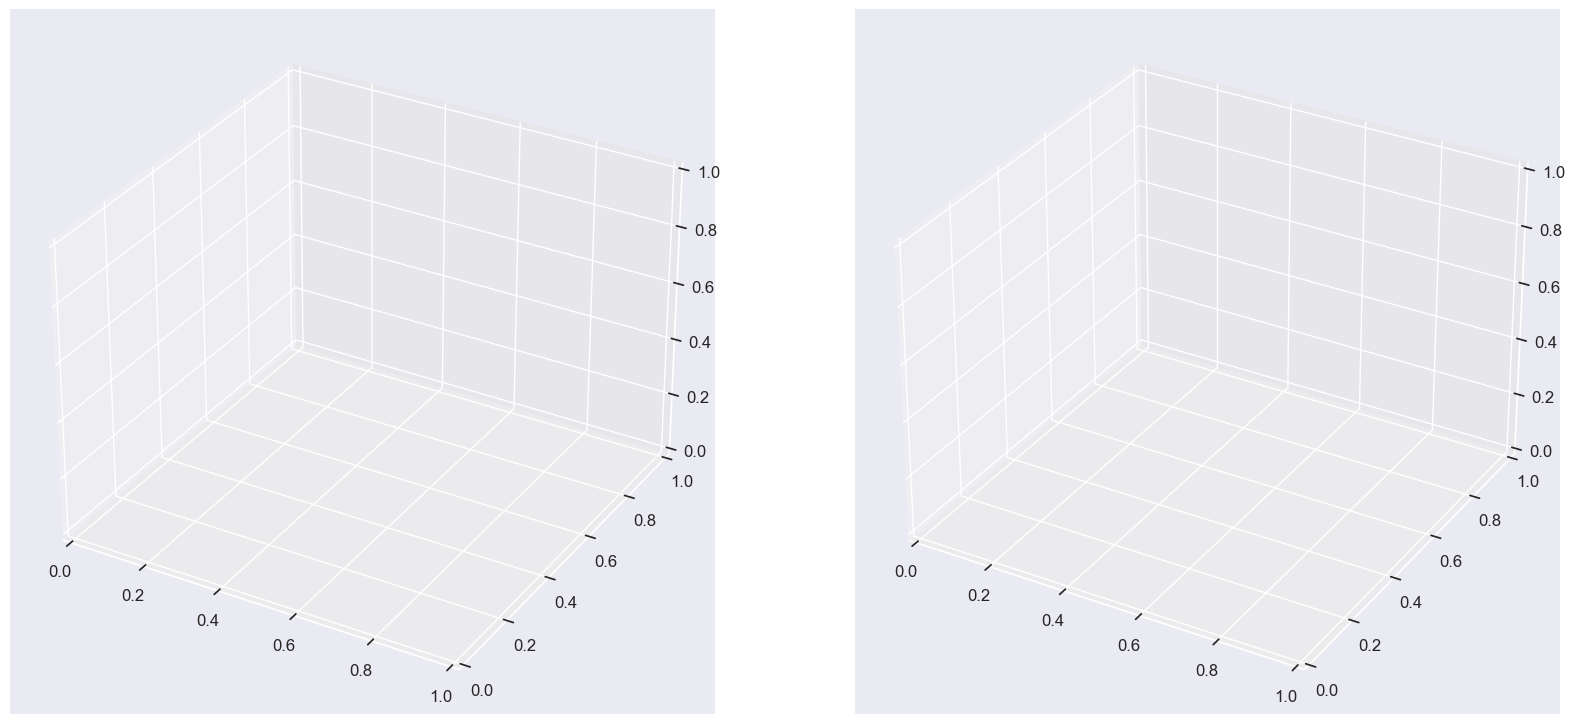

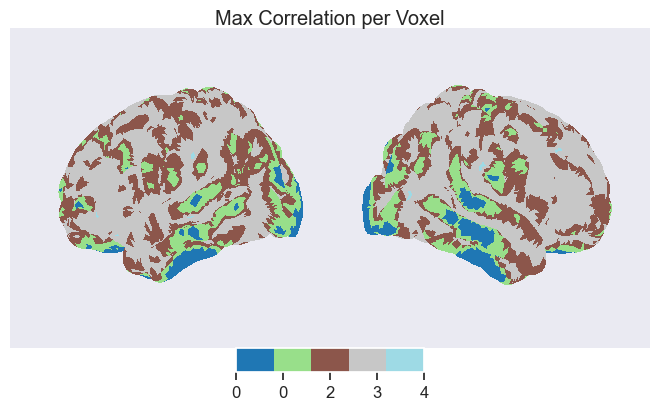

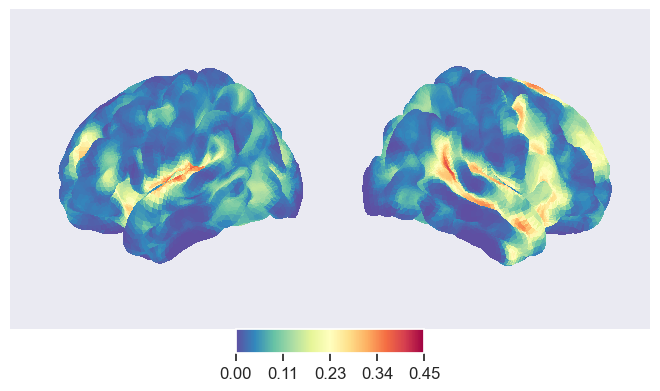

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import matplotlib.colors as mcolors

# Supposons que vos données sont déjà chargées dans les variables correspondantes
# corr_random_emb_300, corr_random_emb_1024, etc.

# Créez une liste de toutes les corrélations
all_correlations = [corr_random_vec_1024, corr_lograndom_vec_1024,
                    corr_exprandom_vec_1024, corr_georandom_vec_1024, corr_cauchyrandom_vec_1024]

# Convertissez la liste en un tableau numpy
all_correlations = np.array(all_correlations)

# Trouvez l'indice du bruit avec la corrélation maximale pour chaque voxel
max_corr_indices = np.argmax(all_correlations, axis=0)
max_corr = np.max(all_correlations, axis=0)

# Créez une image où chaque voxel est coloré en fonction de l'indice maximal
imgtmp = nifti_masker.inverse_transform(max_corr_indices)
imgtmp2 = nifti_masker.inverse_transform(max_corr)

# Définissez les noms des bruits pour l'affichage
noms = ['corr_random_vec_1024', 'corr_lograndom_vec_1024',
        'corr_exprandom_vec_1024', 'corr_georandom_vec_1024', 'corr_cauchyrandom_vec_1024']

# Créez une colormap personnalisée
cmap = plt.get_cmap('tab20', len(noms))

# Créez les couleurs pour chaque nom
colors = cmap(np.arange(len(noms)))

# Créez une légende pour les couleurs
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(len(noms) + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Créez la figure et les axes pour l'affichage
fig, axes = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})

# Plot the first brain image
display = plotting.plot_img_on_surf(imgtmp,
                                    surf_mesh='fsaverage5',
                                    views=['lateral'],
                                    hemispheres=['left', 'right'],
                                    vmin=-0.5, vmax=len(noms) - 0.5,
                                    cmap=cmap,
                                    colorbar=True,
                                    title='Max Correlation per Voxel')
plt.savefig('unique_plot_max_correlation.png', bbox_inches='tight')
# Plot the second brain image
display2 = plotting.plot_img_on_surf(imgtmp2,
                                     surf_mesh='fsaverage5',
                                     views=['lateral'],
                                     hemispheres=['left', 'right'],
                                     vmin=0., vmax=vmax,
                                     cmap='Spectral_r',
                                     symmetric_cbar=False,
                                     cbar_tick_format='%.2f',
                                     colorbar=True,
                                     title="")


/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


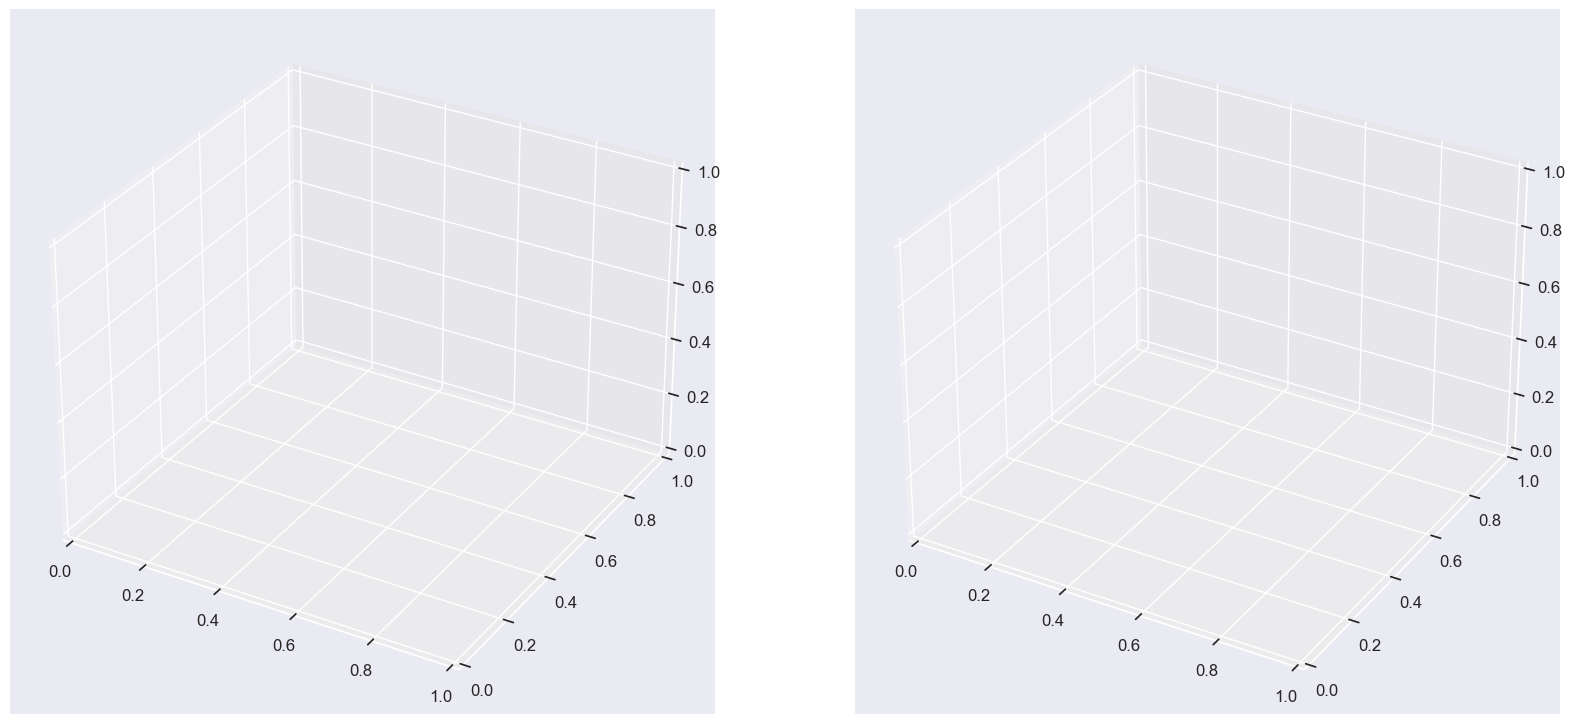

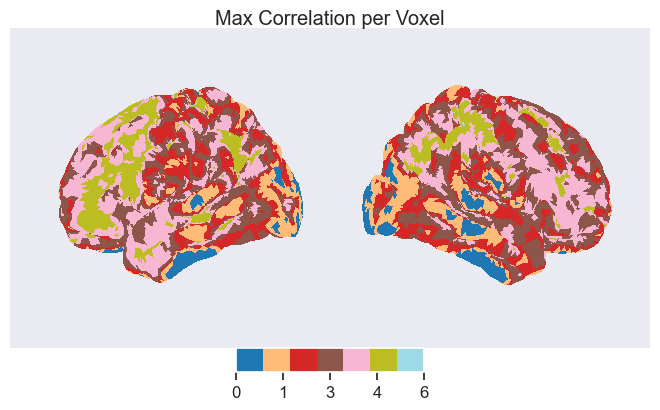

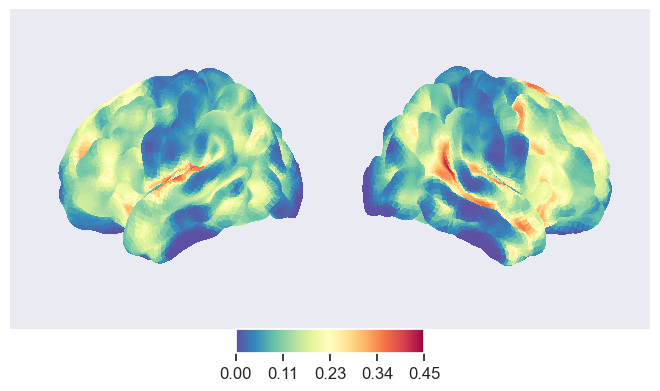

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import matplotlib.colors as mcolors

# Supposons que vos données sont déjà chargées dans les variables correspondantes
# corr_random_emb_300, corr_random_emb_1024, etc.

# Créez une liste de toutes les corrélations
all_correlations = [corr_random_emb_300, corr_random_emb_1024, corr2_random_emb_1024,
                    corr_lograndom_emb_1024, corr_exprandom_emb_1024, corr_cauchyrandom_emb_1024,
                    corr_georandom_emb_1024]

# Convertissez la liste en un tableau numpy
all_correlations = np.array(all_correlations)

# Trouvez l'indice du bruit avec la corrélation maximale pour chaque voxel
max_corr_indices = np.argmax(all_correlations, axis=0)
max_corr = np.max(all_correlations, axis=0)

# Créez une image où chaque voxel est coloré en fonction de l'indice maximal
imgtmp = nifti_masker.inverse_transform(max_corr_indices)
imgtmp2 = nifti_masker.inverse_transform(max_corr)

# Définissez les noms des bruits pour l'affichage
noms = ['corr_random_emb_300', 'corr_random_emb_1024', 'corr2_random_emb_1024',
        'corr_lograndom_emb_1024', 'corr_exprandom_emb_1024', 'corr_cauchyrandom_emb_1024',
        'corr_georandom_emb_1024']
# Créez une colormap personnalisée
cmap = plt.get_cmap('tab20', len(noms))

# Créez les couleurs pour chaque nom
colors = cmap(np.arange(len(noms)))

# Créez une légende pour les couleurs
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(len(noms) + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Créez la figure et les axes pour l'affichage
fig, axes = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})

# Plot the first brain image
display = plotting.plot_img_on_surf(imgtmp,
                                    surf_mesh='fsaverage5',
                                    views=['lateral'],
                                    hemispheres=['left', 'right'],
                                    vmin=-0.5, vmax=len(noms) - 0.5,
                                    cmap=cmap,
                                    colorbar=True,
                                    title='Max Correlation per Voxel')
plt.savefig('unique_plot_max_correlation.png', bbox_inches='tight')
# Plot the second brain image
display2 = plotting.plot_img_on_surf(imgtmp2,
                                     surf_mesh='fsaverage5',
                                     views=['lateral'],
                                     hemispheres=['left', 'right'],
                                     vmin=0., vmax=vmax,
                                     cmap='Spectral_r',
                                     symmetric_cbar=False,
                                     cbar_tick_format='%.2f',
                                     colorbar=True,
                                     title="")


In [117]:
noms = ['corr_random_emb_300', 'corr_random_emb_1024', 'corr2_random_emb_1024',
        'corr_lograndom_emb_1024', 'corr_exprandom_emb_1024', 'corr_cauchyrandom_emb_1024',
        'corr_georandom_emb_1024', 'corr_glove']

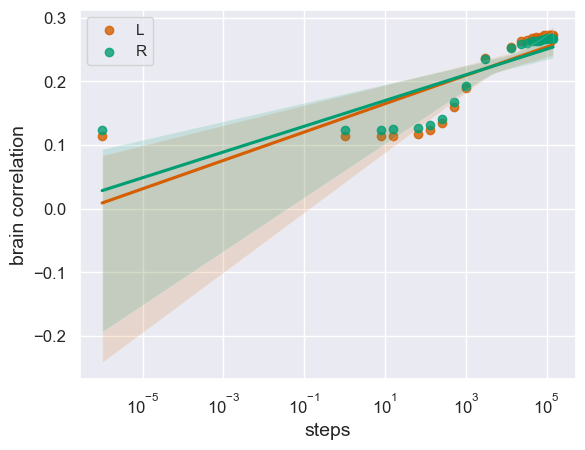

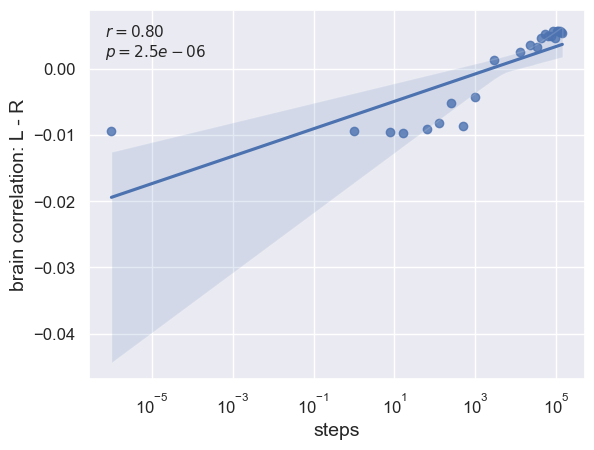

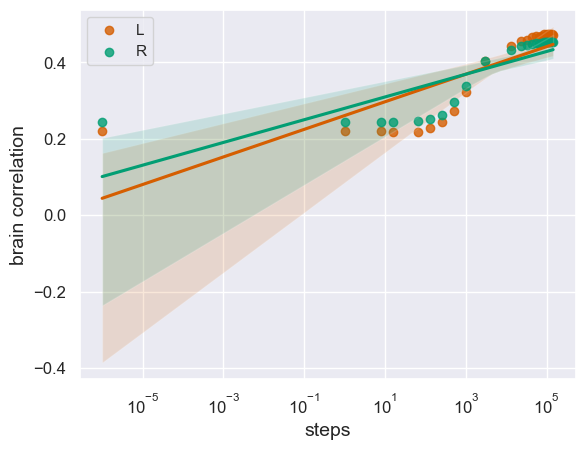

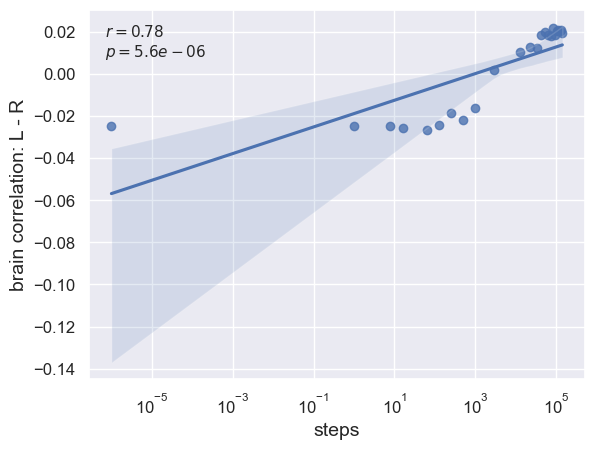

In [118]:
fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=steps, 
            y=np.mean(corr_l_models, axis=1),
            logx=True, ax=ax, label='L', color=l_r_colors[0]);
sns.regplot(x=steps, 
            y=np.mean(corr_r_models, axis=1),
            logx=True, ax=ax, label='R', color=l_r_colors[1]);
ax.set_xscale('log')
ax.set_xlabel('steps')      
ax.set_ylabel('brain correlation')
plt.legend()
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_r_all_mean.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=steps, 
            y=np.mean(corr_l_models, axis=1)-np.mean(corr_r_models, axis=1), 
            logx=True, ax=ax);
ax.set_xscale('log')
ax.set_xlabel('steps')      
ax.set_ylabel('brain correlation: L - R')
r, p = pearsonr(np.log(steps), (np.mean(corr_l_models, axis=1)
                                      -np.mean(corr_r_models, axis=1)))
fh.text(0.15, 0.85,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
        ha='left', va='top', fontsize=11)
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_minus_r_all.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=steps, 
            y=np.percentile(corr_l_models, 90, axis=1),
            logx=True, ax=ax, label='L', color=l_r_colors[0]);
sns.regplot(x=steps, 
            y=np.percentile(corr_r_models, 90, axis=1),
            logx=True, ax=ax, label='R', color=l_r_colors[1]);
ax.set_xscale('log')
ax.set_xlabel('steps')      
ax.set_ylabel('brain correlation')
plt.legend()
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_r_all_90.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=steps, 
            y=np.percentile(corr_l_models, 90, axis=1)-np.percentile(corr_r_models, 90, axis=1),
            logx=True, ax=ax);
ax.set_xscale('log')
ax.set_xlabel('steps')      
ax.set_ylabel('brain correlation: L - R')
r, p = pearsonr(np.log(steps), (np.percentile(corr_l_models, 90, axis=1)
                                      -np.percentile(corr_r_models, 90, axis=1)))
fh.text(0.15, 0.85,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
        ha='left', va='top', fontsize=11)
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_minus_r_all_90.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

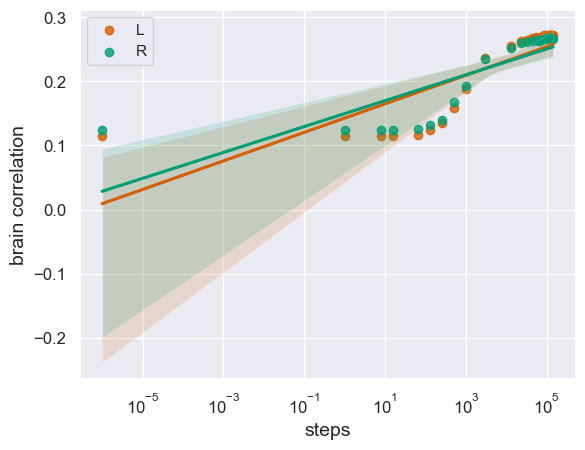

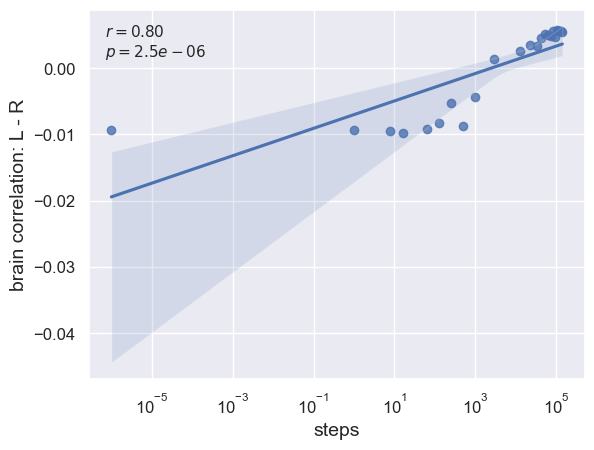

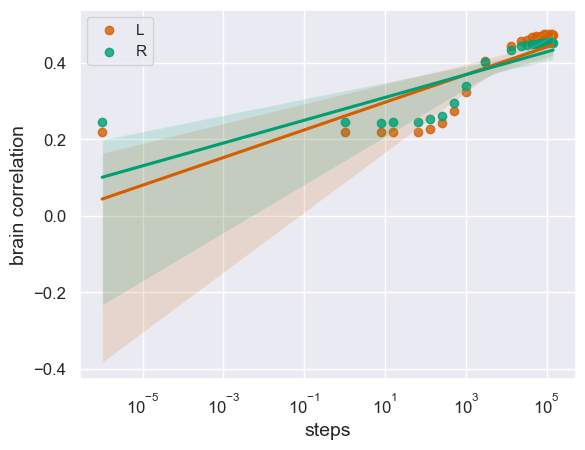

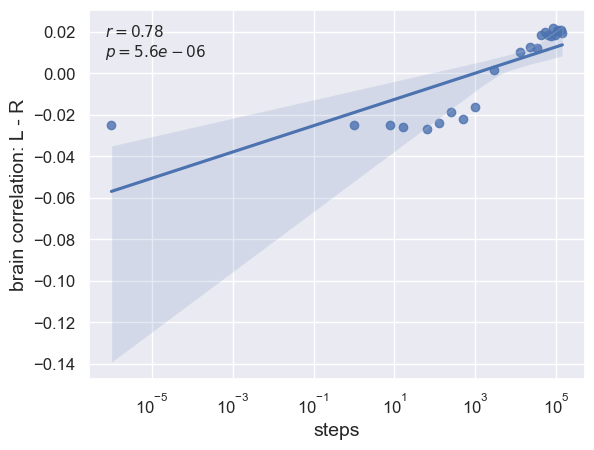

In [119]:
fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=steps, 
            y=np.mean(corr_l_models, axis=1),
            logx=True, ax=ax, label='L', color=l_r_colors[0]);
sns.regplot(x=steps, 
            y=np.mean(corr_r_models, axis=1),
            logx=True, ax=ax, label='R', color=l_r_colors[1]);
ax.set_xscale('log')
ax.set_xlabel('steps')      
ax.set_ylabel('brain correlation')
plt.legend()
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_r_all_mean.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=steps, 
            y=np.mean(corr_l_models, axis=1)-np.mean(corr_r_models, axis=1), 
            logx=True, ax=ax);
ax.set_xscale('log')
ax.set_xlabel('steps')      
ax.set_ylabel('brain correlation: L - R')
r, p = pearsonr(np.log(steps), (np.mean(corr_l_models, axis=1)
                                      -np.mean(corr_r_models, axis=1)))
fh.text(0.15, 0.85,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
        ha='left', va='top', fontsize=11)
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_minus_r_all.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=steps, 
            y=np.percentile(corr_l_models, 90, axis=1),
            logx=True, ax=ax, label='L', color=l_r_colors[0]);
sns.regplot(x=steps, 
            y=np.percentile(corr_r_models, 90, axis=1),
            logx=True, ax=ax, label='R', color=l_r_colors[1]);
ax.set_xscale('log')
ax.set_xlabel('steps')      
ax.set_ylabel('brain correlation')
plt.legend()
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_r_all_90.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=steps, 
            y=np.percentile(corr_l_models, 90, axis=1)-np.percentile(corr_r_models, 90, axis=1),
            logx=True, ax=ax);
ax.set_xscale('log')
ax.set_xlabel('steps')      
ax.set_ylabel('brain correlation: L - R')
r, p = pearsonr(np.log(steps), (np.percentile(corr_l_models, 90, axis=1)
                                      -np.percentile(corr_r_models, 90, axis=1)))
fh.text(0.15, 0.85,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
        ha='left', va='top', fontsize=11)
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_minus_r_all_90.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

In [120]:
# on the most 25% reliable voxels

#l r asym in baselines
for corr_voxels in [corr_random_emb_300, corr_random_emb_1024,
                    corr_glove]:
    print(corr_voxels[:n_voxels//2][is_voxel_reliable[:n_voxels//2]].mean()
          - corr_voxels[n_voxels//2:][is_voxel_reliable[n_voxels//2:]].mean())

-0.035731043089173437
-0.02852427242662131
-0.0027494835576180043


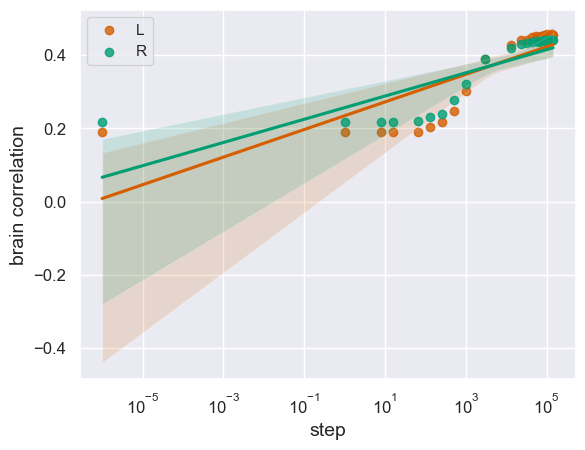

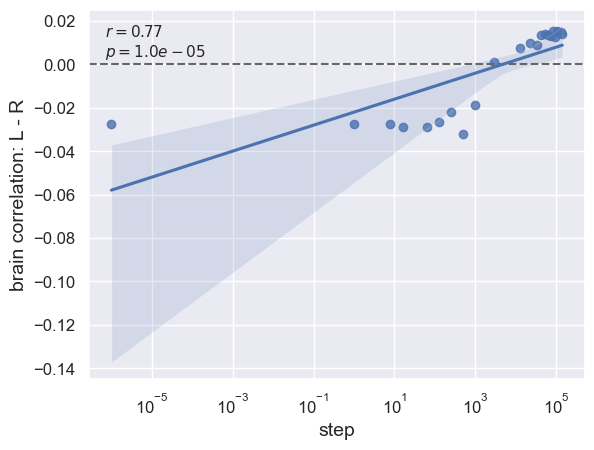

In [121]:
fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=steps, 
            y=np.mean(corr_l_models_rv, axis=1),
            logx=True, ax=ax, label='L', color=l_r_colors[0]);
sns.regplot(x=steps, 
            y=np.mean(corr_r_models_rv, axis=1),
            logx=True, ax=ax, label='R', color=l_r_colors[1]);
ax.set_xscale('log')
ax.set_xlabel('step')      
ax.set_ylabel('brain correlation')
plt.legend()
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_r_all_mean_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=steps, 
            y=(np.mean(corr_l_models_rv, axis=1)
               -np.mean(corr_r_models_rv, axis=1)), 
            logx=True, ax=ax);
ax.set_xscale('log')
ax.set_xlabel('step')      
ax.set_ylabel('brain correlation: L - R')
ax.axhline(0., ls='--', c='0.4', zorder=1);
r, p = pearsonr(np.log(steps), (np.mean(corr_l_models_rv, axis=1)
                                      -np.mean(corr_r_models_rv, axis=1)))
fh.text(0.15, 0.85,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
        ha='left', va='top', fontsize=11)
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_minus_r_all_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

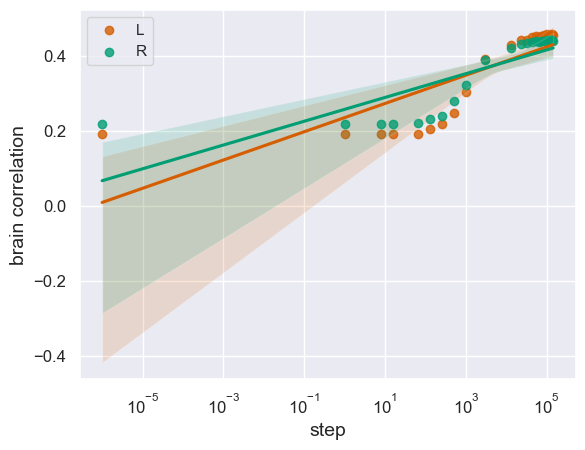

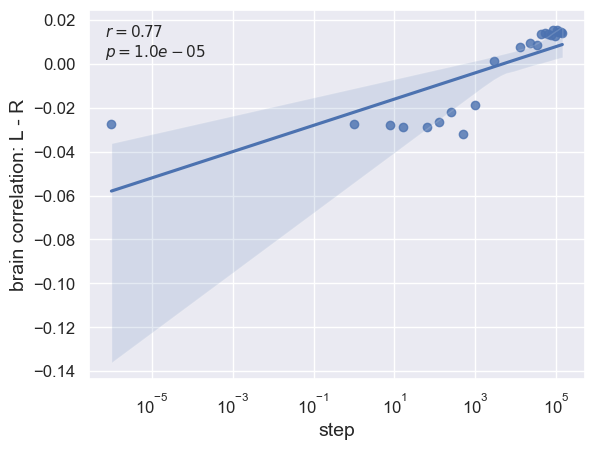

In [122]:
fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=steps, 
            y=np.mean(corr_l_models_rv, axis=1),
            logx=True, ax=ax, label='L', color=l_r_colors[0]);
sns.regplot(x=steps, 
            y=np.mean(corr_r_models_rv, axis=1),
            logx=True, ax=ax, label='R', color=l_r_colors[1]);
ax.set_xscale('log')
ax.set_xlabel('step')      
ax.set_ylabel('brain correlation')
plt.legend()
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_r_all_mean_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=steps, 
            y=(np.mean(corr_l_models_rv, axis=1)
               -np.mean(corr_r_models_rv, axis=1)), 
            logx=True, ax=ax);
ax.set_xscale('log')
ax.set_xlabel('step')      
ax.set_ylabel('brain correlation: L - R')
r, p = pearsonr(np.log(steps), (np.mean(corr_l_models_rv, axis=1)
                                      -np.mean(corr_r_models_rv, axis=1)))
fh.text(0.15, 0.85,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
        ha='left', va='top', fontsize=11)
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_minus_r_all_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

In [123]:
print(np.shape(corr_voxels_models))
corr_voxels_models = np.array(corr_voxels_models)

(24, 25870)


7.74804675509196


/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/nilearn/plotting/img_plotting.py:1431: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


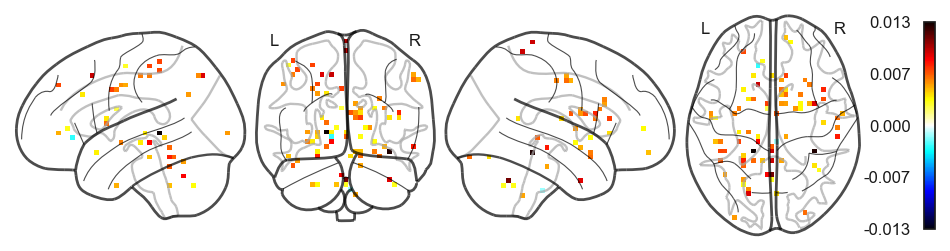

In [124]:
################################ Slopes, voxelwise ################################
slopes = []
tvalues = []
pvalues = []
for idx_voxel in range(n_voxels):
    y = corr_voxels_models[:, idx_voxel]
    x = np.log(steps)
    x = sm.add_constant(x)
    lm = sm.OLS(y, x)
    res = lm.fit()
    slopes.append(res.params[1])
    tvalues.append(res.tvalues[1])
    pvalues.append(res.pvalues[1])

slopes = np.array(slopes)
tvalues = np.array(tvalues)
pvalues = np.array(pvalues)

vtmp = slopes.copy()
p_thsld = 10**-7
t_thsld = np.abs(scipy.stats.t.ppf(p_thsld/2, df=n_models-2)) #two-sided
print(t_thsld)
vtmp[np.abs(tvalues) < t_thsld] = np.nan
imgtmp = nifti_masker.inverse_transform(vtmp)

fh = plt.figure(figsize=(12,3))
ax = plt.subplot(111)
plotting.plot_glass_brain(imgtmp, threshold=0., display_mode='lyrz', cbar_tick_format='%.3f',
                          plot_abs=False, colorbar=True, axes=ax)
plotting.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'glassbrain_slopes.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

In [125]:
################################ ROIs analysis ################################

roi_names = ['TP', 'aSTS', 'pSTS', 'AG_TPJ', 'BA44', 'BA45', 'BA47']
n_rois = len(roi_names)
folder_mask = 'roi_masks'

roi_list = [os.path.join(folder_mask, '{}.nii.gz'.format(roi_name)) for roi_name in roi_names]
roi_list_r = [swap_img_hemispheres(roi_mask) for roi_mask in roi_list]
rois_t = nifti_masker.transform(roi_list + roi_list_r)
idx_rois = [np.flatnonzero(roi_t == 1.0) for roi_t in rois_t]

59.0
56.0
69.0
56.0
56.0
53.0
81.0


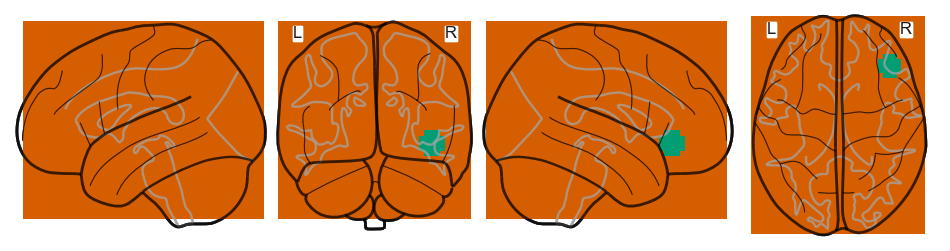

In [126]:
cmap = ListedColormap(l_r_colors)

fh = plt.figure(figsize=(12,3))
ax = plt.subplot(111)
for vtmp in rois_t[:n_rois]:
    print(np.sum(vtmp))
    imgtmp = nifti_masker.inverse_transform(vtmp)
    plotting.plot_glass_brain(imgtmp, display_mode='lyrz', cmap=cmap, axes=ax, alpha=0.1)
for vtmp in rois_t[n_rois:]:
    imgtmp = nifti_masker.inverse_transform(vtmp)
    plotting.plot_glass_brain(imgtmp, display_mode='lyrz', cmap=cmap, axes=ax, alpha=0.1)
plotting.plot_glass_brain(None,  display_mode='lyrz', axes=ax)
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'rois_l_r.pdf'), bbox_inches='tight', transparent=True)
    fh.savefig(os.path.join(fig_folder, 'rois_l_r.svg'), bbox_inches='tight', transparent=True)

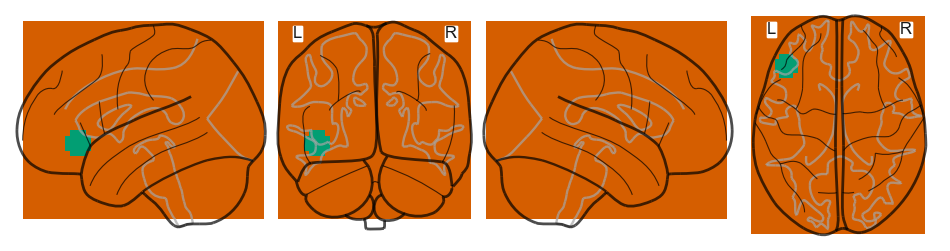

In [127]:
import os
import numpy as np
from nilearn import plotting
from nilearn.image import load_img
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# ROIs analysis ###############################

roi_names = ['TP', 'aSTS', 'pSTS', 'AG_TPJ', 'BA44', 'BA45', 'BA47']
n_rois = len(roi_names)
folder_mask = 'roi_masks'

roi_list = [os.path.join(folder_mask, '{}.nii.gz'.format(roi_name)) for roi_name in roi_names]
roi_list_t = [swap_img_hemispheres(roi_mask) for roi_mask in roi_list]
rois_t = nifti_masker.transform(roi_list_t + roi_list)
idx_rois = [np.flatnonzero(roi == 1.0) for roi in rois_t]

# Plotting code ###############################

cmap = ListedColormap(l_r_colors)

fh = plt.figure(figsize=(12, 3))
ax = plt.subplot(111)

# Plot transformed ROIs
for vtmp in rois_t:
    imgtmp = nifti_masker.inverse_transform(vtmp)
    plotting.plot_glass_brain(imgtmp, display_mode='lyrz', cmap=cmap, axes=ax, alpha=0.)

plotting.plot_glass_brain(None, display_mode='lyrz', axes=ax)

plt.show()

if True:
    fh.savefig(os.path.join(fig_folder, 'rois_lr.pdf'), bbox_inches='tight', transparent=True)
    fh.savefig(os.path.join(fig_folder, 'rois_lr.svg'), bbox_inches='tight', transparent=True)


14
7
[ 929  930  947  948 1418 1439 1440 1441 1442 1459 1460 1461 1462 1479
 1480 1481 2024 2025 2047 2048 2049 2050 2068 2069 2070 2071 2072 2090
 2091 2092 2093 2110 2111 2112 2720 2744 2745 2746 2747 2767 2768 2769
 2770 2771 2791 2792 2793 2794 2812 2813 2814 3526 3527 3550 3551 3552
 3575 3576 3577]


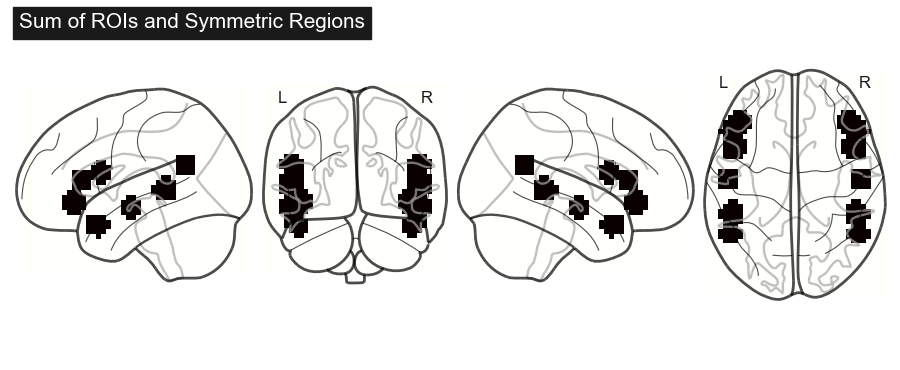

In [128]:
import os
import numpy as np
from nilearn import plotting
from nilearn.image import load_img, math_img, new_img_like

roi_names = ['TP', 'aSTS', 'pSTS', 'AG_TPJ', 'BA44', 'BA45', 'BA47']
n_rois = len(roi_names)
folder_mask = 'roi_masks'

roi_list = [os.path.join(folder_mask, '{}.nii.gz'.format(roi_name)) for roi_name in roi_names]
roi_list_r = [swap_img_hemispheres(roi_mask) for roi_mask in roi_list]
rois_t = nifti_masker.transform(roi_list + roi_list_r)
idx_rois = [np.flatnonzero(roi_t == 1.0) for roi_t in rois_t]
print(len(idx_rois))
print(len(roi_names))
print(idx_rois[0])

# Fonction pour créer une image symétrique
def create_symmetric_image(img):
    data = img.get_fdata()
    affine = img.affine
    # Inversion des coordonnées gauche-droite (axe x)
    data_symmetric = np.flip(data, axis=0)
    symmetric_img = new_img_like(img, data_symmetric, affine)
    return symmetric_img

# Charger la première image de masque pour initier la somme
sum_img = load_img(roi_list[0])
symmetric_img = create_symmetric_image(sum_img)

# Additionner l'image originale et la symétrique
combined_img = math_img("img1 + img2", img1=sum_img, img2=symmetric_img)

# Ajouter les autres images de masque et leurs symétriques
for roi in roi_list[1:]:
    img = load_img(roi)
    sym_img = create_symmetric_image(img)
    combined_img = math_img("img1 + img2 + img3", img1=combined_img, img2=img, img3=sym_img)

# Afficher l'image combinée sur un Glass brain
plotting.plot_glass_brain(combined_img, title='Sum of ROIs and Symmetric Regions', display_mode='lyrz')

# Affichage des graphiques
plotting.show()


In [129]:
# Calculate delta_slope and delta_corr_model
deltaslope = np.array(slopes[:n_voxels//2]) - np.array(slopes[n_voxels//2:])
delta_corr_model = np.array(corr_voxels_models[:, :n_voxels//2]) - np.array(corr_voxels_models[:, n_voxels//2:])
colors = plt.cm.rainbow(np.linspace(0, 1, n_rois))
barycenter_y = np.mean(deltaslope)
barycenter_x = np.mean(delta_corr_model[:, :], axis=1)
# Function to plot and save graphs for each value of i
def plot_graph(i):
    plt.figure(figsize=(8, 6))
    plt.scatter(delta_corr_model[i, :], deltaslope, label='All Points')
    for j, (idx_roi, roi_name) in enumerate(zip(idx_rois, roi_names)):
        plt.scatter(delta_corr_model[i, idx_roi], deltaslope[idx_roi], color=colors[j], label=f'{roi_name} (i={i})')
    plt.scatter(barycenter_x[i], barycenter_y, color='black', marker='x', s=100, label='Barycenter')
    plt.xlabel("delta correlation L-R")
    plt.ylabel('delta slope L-R')
    plt.title("delta slope vs delta correlation")
    plt.axhline(0, -0.5, 1, color='black')
    plt.legend()
    plt.show()

# Create an interactive slider to change the value of i
from ipywidgets import interact
interact(plot_graph, i=(0, 14, 1));


interactive(children=(IntSlider(value=7, description='i', max=14), Output()), _dom_classes=('widget-interact',…

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Supposons que les variables suivantes soient déjà définies
# n_voxels, slopes, corr_voxels_models, corr_lograndom_emb_1024, idx_rois, roi_names

# Calculate delta_slope and delta_corr_model
deltaslope = np.array(slopes[:n_voxels // 2]) - np.array(slopes[n_voxels // 2:])
delta_corr_model = np.array(corr_voxels_models[:, :n_voxels // 2]) - np.array(corr_voxels_models[:, n_voxels // 2:]) + np.array(corr_lograndom_emb_1024[n_voxels // 2:]) - np.array(corr_lograndom_emb_1024[:n_voxels // 2])
colors = plt.cm.rainbow(np.linspace(0, 1, len(idx_rois)))
barycenter_y = np.mean(deltaslope)
barycenter_x = np.mean(delta_corr_model[:, :], axis=1)

# Function to plot and save graphs for each value of i
def plot_graph(i):
    plt.figure(figsize=(8, 6))
    plt.scatter(delta_corr_model[i, :], deltaslope, label='All Points')
    for j, (idx_roi, roi_name) in enumerate(zip(idx_rois, roi_names)):
        plt.scatter(delta_corr_model[i, idx_roi], deltaslope[idx_roi], color=colors[j], label=f'{roi_name} (i={i})')
    plt.scatter(barycenter_x[i], barycenter_y, color='black', marker='x', s=100, label='Barycenter')
    plt.xlabel("delta correlation L-R")
    plt.ylabel('delta slope L-R')
    plt.title("delta slope vs delta correlation")
    plt.legend()
    plt.axhline(0, color='black')
    plt.savefig(f"frame_{i}.png")
    plt.close()

# Generate and save all frames
n_frames = 15  # Assumons que vous avez 15 images à générer
for i in range(n_frames):
    plot_graph(i)

# Create a GIF from the saved frames
images = []
for i in range(n_frames):
    filename = f"frame_{i}.png"
    images.append(imageio.imread(filename))
imageio.mimsave('delta vs slope.gif', images, duration=0.5)  # Adjust duration as needed

print("GIF saved as 'brain_correlations.gif'")



/var/folders/ky/0mnswx1j4slddjt0jztl2k6c0000gn/T/ipykernel_40226/3797961887.py:39: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


GIF saved as 'brain_correlations.gif'


TP 	 6.7e-14 	 ***
aSTS 	 1.2e-21 	 ***
pSTS 	 1.8e-17 	 ***
AG_TPJ 	 3.9e-20 	 ***
BA44 	 2.8e-08 	 ***
BA45 	 7.3e-17 	 ***
BA47 	 8.5e-19 	 ***


/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mathisscheffler/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

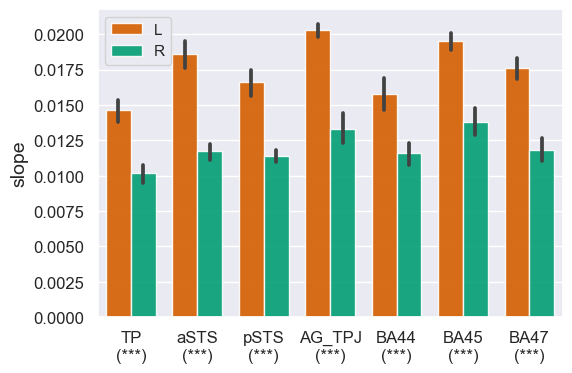

In [131]:
df_roi_slopes = []
for idx_roi, roi_name in zip(idx_rois[0:n_rois], roi_names):
    df_roi_slopes.append(pd.DataFrame({'roi':roi_name,
                  'slope':slopes[idx_roi],
                  'hemi':'L'}))
for idx_roi, roi_name in zip(idx_rois[n_rois:], roi_names):
    df_roi_slopes.append(pd.DataFrame({'roi':roi_name,
                  'slope':slopes[idx_roi],
                  'hemi':'R'}))
df_roi_slopes = pd.concat(df_roi_slopes)

xtickslabels_roi = []
for roi_name in roi_names:
    ttest = ttest_ind(df_roi_slopes[(df_roi_slopes['roi']==roi_name)&(df_roi_slopes['hemi']=='L')].slope,
              df_roi_slopes[(df_roi_slopes['roi']==roi_name)&(df_roi_slopes['hemi']=='R')].slope)
    print(roi_name, '\t', 
          '{:.01e}'.format(ttest.pvalue), '\t', pvalue2str(ttest.pvalue))
    xtickslabels_roi.append('{}\n({})'.format(roi_name, pvalue2str(ttest.pvalue)))

fh = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)
sns.barplot(data=df_roi_slopes, x='roi', y='slope', hue='hemi', 
            palette=l_r_colors, saturation=1.0, width=0.75, alpha=0.9,
            ax=ax)
plt.legend(loc='upper left')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(xtickslabels_roi)
ax.set_xlabel('')
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'rois_slopes.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

In [132]:
print(np.shape(corr_voxels_models))

(24, 25870)


TP 	 0.77 	 1.1e-05
aSTS 	 0.80 	 3.0e-06
pSTS 	 0.79 	 5.5e-06
AG_TPJ 	 0.77 	 9.4e-06
BA44 	 0.84 	 3.5e-07
BA45 	 0.84 	 3.4e-07
BA47 	 0.82 	 1.1e-06


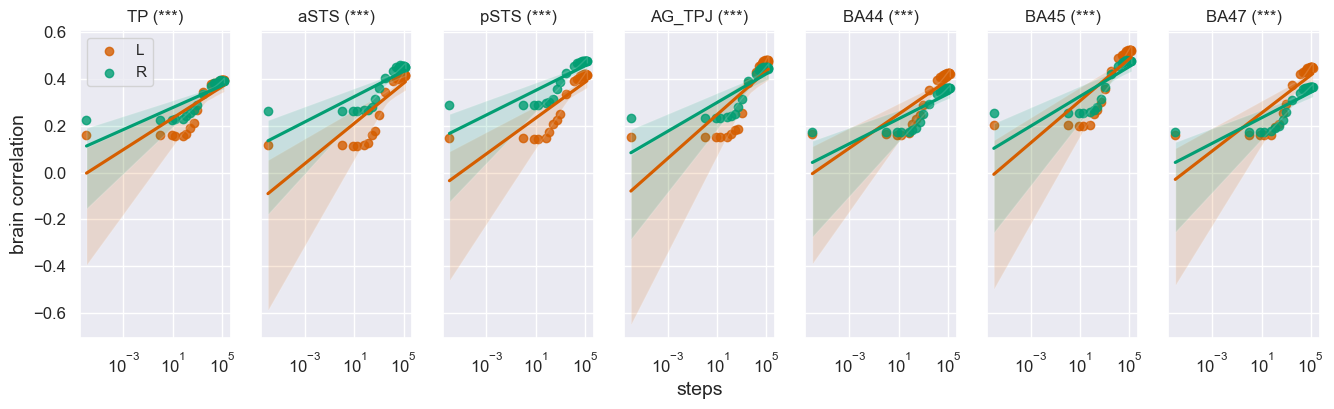

In [133]:
fh, axes = plt.subplots(1, n_rois, figsize=(16,4), sharey=True)
for i, (idx_roi_l, idx_roi_r, roi_name) in enumerate(zip(idx_rois[:n_rois], idx_rois[n_rois:], roi_names)):
    ax = axes[i]
    sns.regplot(x=steps, 
                y=np.mean(corr_voxels_models[:,idx_roi_l], axis=1),
                logx=True, color=l_r_colors[0], ax=ax, label='L');   
    sns.regplot(x=steps, 
                y=np.mean(corr_voxels_models[:,idx_roi_r], axis=1),
                logx=True, color=l_r_colors[1], ax=ax, label='R');   
    ax.set_xscale('log')

    r, p = pearsonr(np.log(steps), 
                 (np.mean(corr_voxels_models[:,idx_roi_l], axis=1)
                  -np.mean(corr_voxels_models[:,idx_roi_r], axis=1)))
    print(roi_name, '\t', '{:.2f}'.format(r), '\t', '{:.1e}'.format(p))
    ax.set_title('{} ({})'.format(roi_name, pvalue2str(p)))

    
axes[n_rois//2].set_xlabel('steps')      
axes[0].set_ylabel('brain correlation')
axes[0].legend(loc='upper left')
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'rois_l_r_corr.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

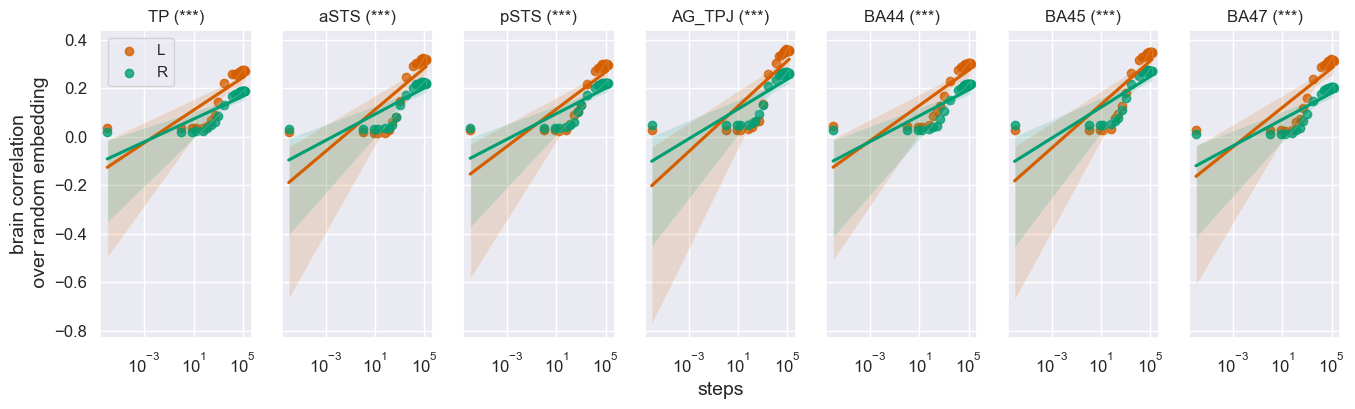

In [134]:
corr_random = corr_random_emb_1024
fh, axes = plt.subplots(1, n_rois, figsize=(16,4), sharey=True)
for i, (idx_roi_l, idx_roi_r, roi_name) in enumerate(zip(idx_rois[:n_rois], idx_rois[n_rois:], roi_names)):
    ax = axes[i]
    sns.regplot(x=steps, 
                y=np.mean(corr_voxels_models[:,idx_roi_l] - corr_random[idx_roi_l], axis=1),
                logx=True, color=l_r_colors[0], ax=ax, label='L'); 
    sns.regplot(x=steps, 
                y=np.mean(corr_voxels_models[:,idx_roi_r] - corr_random[idx_roi_r], axis=1),
                logx=True, color=l_r_colors[1], ax=ax, label='R'); 
    ax.set_xscale('log')
    ax.set_title(roi_name)
    
    r, p = pearsonr(np.log(steps),
                 (np.mean(corr_voxels_models[:,idx_roi_l], axis=1)
                  -np.mean(corr_voxels_models[:,idx_roi_r], axis=1)))
    ax.set_title('{} ({})'.format(roi_name, pvalue2str(p)))
    
axes[n_rois//2].set_xlabel('steps')
axes[0].set_ylabel('brain correlation\n over random embedding')
axes[0].legend(loc='upper left')

plt.show()


if save_fig:
    fh.savefig(os.path.join(fig_folder, 'rois_l_r_corr_over_random.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

In [135]:
###################### other x-axis: hellaswag, perplexity ######################

fh = plot_xy(ppl_models, corr_models, 'perplexity', 'brain correlation', invert_xaxis=True)
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_ppl_corr.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))
    
fh = plot_xy(hellaswag_models, corr_models, 'hellaswag', 'brain correlation')
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_hellaswag_corr.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plot_xy(ppl_models, corr_models_rv, 'perplexity', 'brain correlation', invert_xaxis=True)
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_ppl_corr_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))
    
fh = plot_xy(hellaswag_models, corr_models_rv, 'hellaswag', 'brain correlation')
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_hellaswag_corr_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

NameError: name 'ppl_models' is not defined

In [ ]:
######## consider only largest model (10 models out of 28)
params_thsld = 3*10**9
print((n_parameters>params_thsld).sum())

10


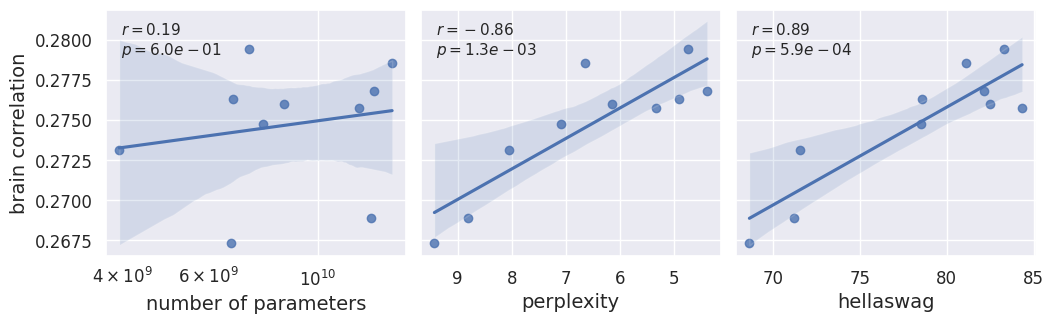

In [ ]:
fh, axes = plt.subplots(1, 3, figsize=(12, 3.2), sharex=False, sharey=True)

ax=axes[0]
sns.regplot(x=n_parameters[n_parameters>params_thsld],
            y=corr_models[n_parameters>params_thsld],
            logx=True, ax=ax);
ax.set_xscale('log')
ax.set_xlabel('number of parameters')      
ax.set_ylabel('brain correlation')
r, p = pearsonr(np.log(n_parameters[n_parameters>params_thsld]), 
                corr_models[n_parameters>params_thsld])
ax.text(0.05, 0.95,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
              ha='left', va='top', fontsize=11, transform=ax.transAxes)

ax=axes[1]
sns.regplot(x=ppl_models[n_parameters>params_thsld],
            y=corr_models[n_parameters>params_thsld],
            ax=ax);
ax.invert_xaxis()
ax.set_xlabel('perplexity')
r, p = pearsonr(ppl_models[n_parameters>params_thsld],
                corr_models[n_parameters>params_thsld])
ax.text(0.05, 0.95,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
              ha='left', va='top', fontsize=11, transform=ax.transAxes)

ax=axes[2]
sns.regplot(x=hellaswag_models[n_parameters>params_thsld],
            y=corr_models[n_parameters>params_thsld],
            ax=ax);
ax.set_xlabel('hellaswag')
r, p = pearsonr(hellaswag_models[n_parameters>params_thsld],
                corr_models[n_parameters>params_thsld])
ax.text(0.05, 0.95,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
              ha='left', va='top', fontsize=11, transform=ax.transAxes)

fh.subplots_adjust(wspace=0.05)

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_corr_above3b.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

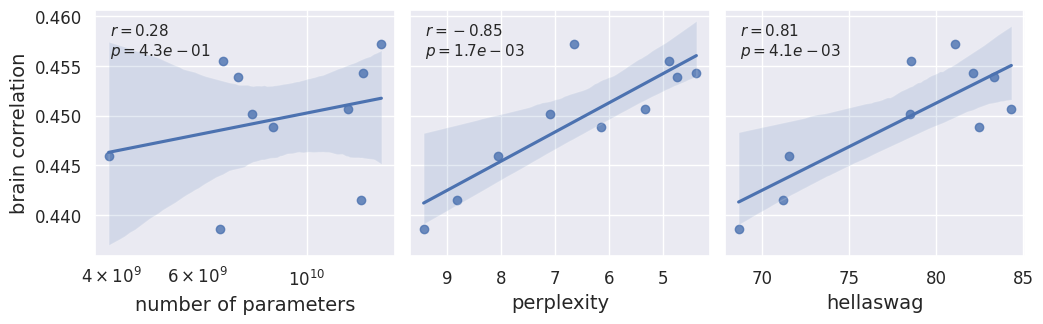

In [ ]:
fh, axes = plt.subplots(1, 3, figsize=(12, 3.2), sharex=False, sharey=True)
ax=axes[0]
sns.regplot(x=n_parameters[n_parameters>params_thsld],
            y=corr_models_rv[n_parameters>params_thsld],
            logx=True, ax=ax);
ax.set_xscale('log')
ax.set_xlabel('number of parameters')      
ax.set_ylabel('brain correlation')
r, p = pearsonr(np.log(n_parameters[n_parameters>params_thsld]), 
                corr_models_rv[n_parameters>params_thsld])
ax.text(0.05, 0.95,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
              ha='left', va='top', fontsize=11, transform=ax.transAxes)

ax=axes[1]
sns.regplot(x=ppl_models[n_parameters>params_thsld],
            y=corr_models_rv[n_parameters>params_thsld],
            ax=ax);
ax.invert_xaxis()
ax.set_xlabel('perplexity')    
r, p = pearsonr(ppl_models[n_parameters>params_thsld],
                corr_models_rv[n_parameters>params_thsld])
ax.text(0.05, 0.95,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
              ha='left', va='top', fontsize=11, transform=ax.transAxes)  

ax=axes[2]
sns.regplot(x=hellaswag_models[n_parameters>params_thsld],
            y=corr_models_rv[n_parameters>params_thsld],
            ax=ax);
ax.set_xlabel('hellaswag') 
r, p = pearsonr(hellaswag_models[n_parameters>params_thsld],
                corr_models_rv[n_parameters>params_thsld])
ax.text(0.05, 0.95,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
              ha='left', va='top', fontsize=11, transform=ax.transAxes)

fh.subplots_adjust(wspace=0.05)

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_corr_above3b_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))